In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/IdanReed/AtariDeepLearning.git
%cd AtariDeepLearning
%load_ext autoreload
%autoreload 2

# Pull data from Vaibhav's google drive
!pip install gdown
!gdown "https://drive.google.com/uc?id=1ExuGJteCja1DQXG_zUAfH6xe4EIFfQfr"
!unzip -q dataset.zip -d /content/dataset


Cloning into 'AtariDeepLearning'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 319 (delta 67), reused 84 (delta 35), pack-reused 185 (from 1)
Receiving objects: 100% (319/319), 154.29 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Filtering content: 100% (2/2), 25.67 MiB | 9.64 MiB/s, done.
/content/AtariDeepLearning
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Downloading...
From (original): https://drive.google.com/uc?id=1ExuGJteCja1DQXG_zUAfH6xe4EIFfQfr
From (redirected): https://drive.google.com/uc?id=1ExuGJteCja1DQXG_zUAfH6xe4EIFfQfr&confirm=t&uuid=bf610189-3ba0-489b-a8d2-a2505c7b8a29
To: /content/AtariDeepLearning/dataset.zip
100% 3.92G/3.92G [00:50<00:00, 78.1MB/s]


In [3]:
%cd /content/AtariDeepLearning
!git pull

/content/AtariDeepLearning
Already up to date.


In [4]:
!pip install optuna

from utils import seed_random_generators
seed_random_generators()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 34.1 MB/s eta 0:00:00


In [5]:
from pathlib import Path
OUTPUT_DIR = Path("output").joinpath("baseline")

from utils import safe_clear_output_dir
safe_clear_output_dir(OUTPUT_DIR)

# Automatically Sync with Github Code

In [6]:
%cd /content/AtariDeepLearning
!git pull

/content/AtariDeepLearning
Already up to date.


# Load Data

In [7]:
from npz_loader import load_episodes

dataset_root = Path("/content/dataset/dataset")
holdout_game_dirs = [
    dataset_root.joinpath("BeamRiderNoFrameskip-v4", "BeamRiderNoFrameskip-v4"),
    dataset_root.joinpath("BreakoutNoFrameskip-v4", "BreakoutNoFrameskip-v4")
]

main_game_dirs = [
    dataset_root.joinpath("EnduroNoFrameskip-v4", "EnduroNoFrameskip-v4"),
    dataset_root.joinpath("MsPacmanNoFrameskip-v4", "MsPacmanNoFrameskip-v4"),
    dataset_root.joinpath("PongNoFrameskip-v4", "PongNoFrameskip-v4"),
    dataset_root.joinpath("QbertNoFrameskip-v4", "QbertNoFrameskip-v4"),
    dataset_root.joinpath("SeaquestNoFrameskip-v4", "SeaquestNoFrameskip-v4"),
    dataset_root.joinpath("SpaceInvadersNoFrameskip-v4", "SpaceInvadersNoFrameskip-v4")
]
episodes = load_episodes(main_game_dirs, holdout_game_dirs, True)

Loaded 1880 episodes


In [8]:
from utils import sample_list
sampled_episodes = sample_list(episodes, fraction=0.10)

Sampled 188 items (10.0% of 1880 total)


In [9]:
from epsiode_dataloader import make_train_val_dataloaders

main_bundle, holdout_bundle, bins = make_train_val_dataloaders(
    episodes=sampled_episodes,
    holdout_game_dirs=holdout_game_dirs,
    train_frac=0.8,
    timestep_window_size=4,
)

# Dataloader - Main Games

Saved plot to output/baseline/dataloader_main_train.png


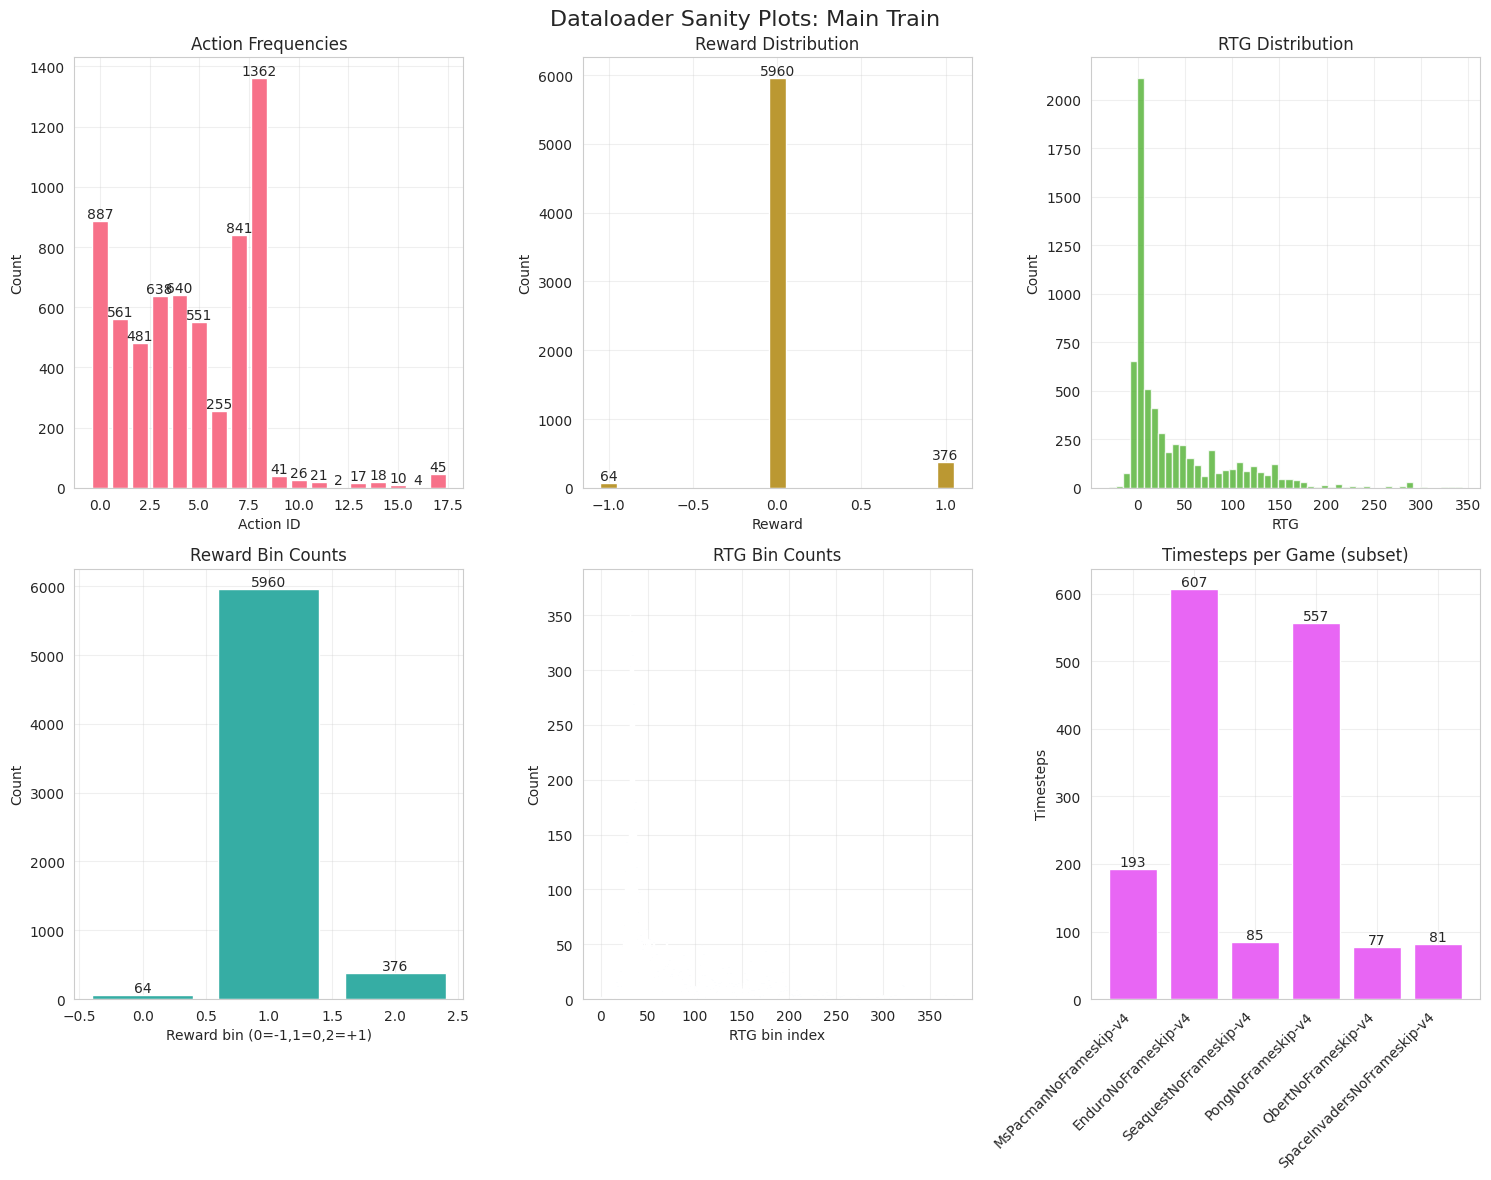

Dataloader size: 4079
Saved plot to output/baseline/dataloader_main_validate.png


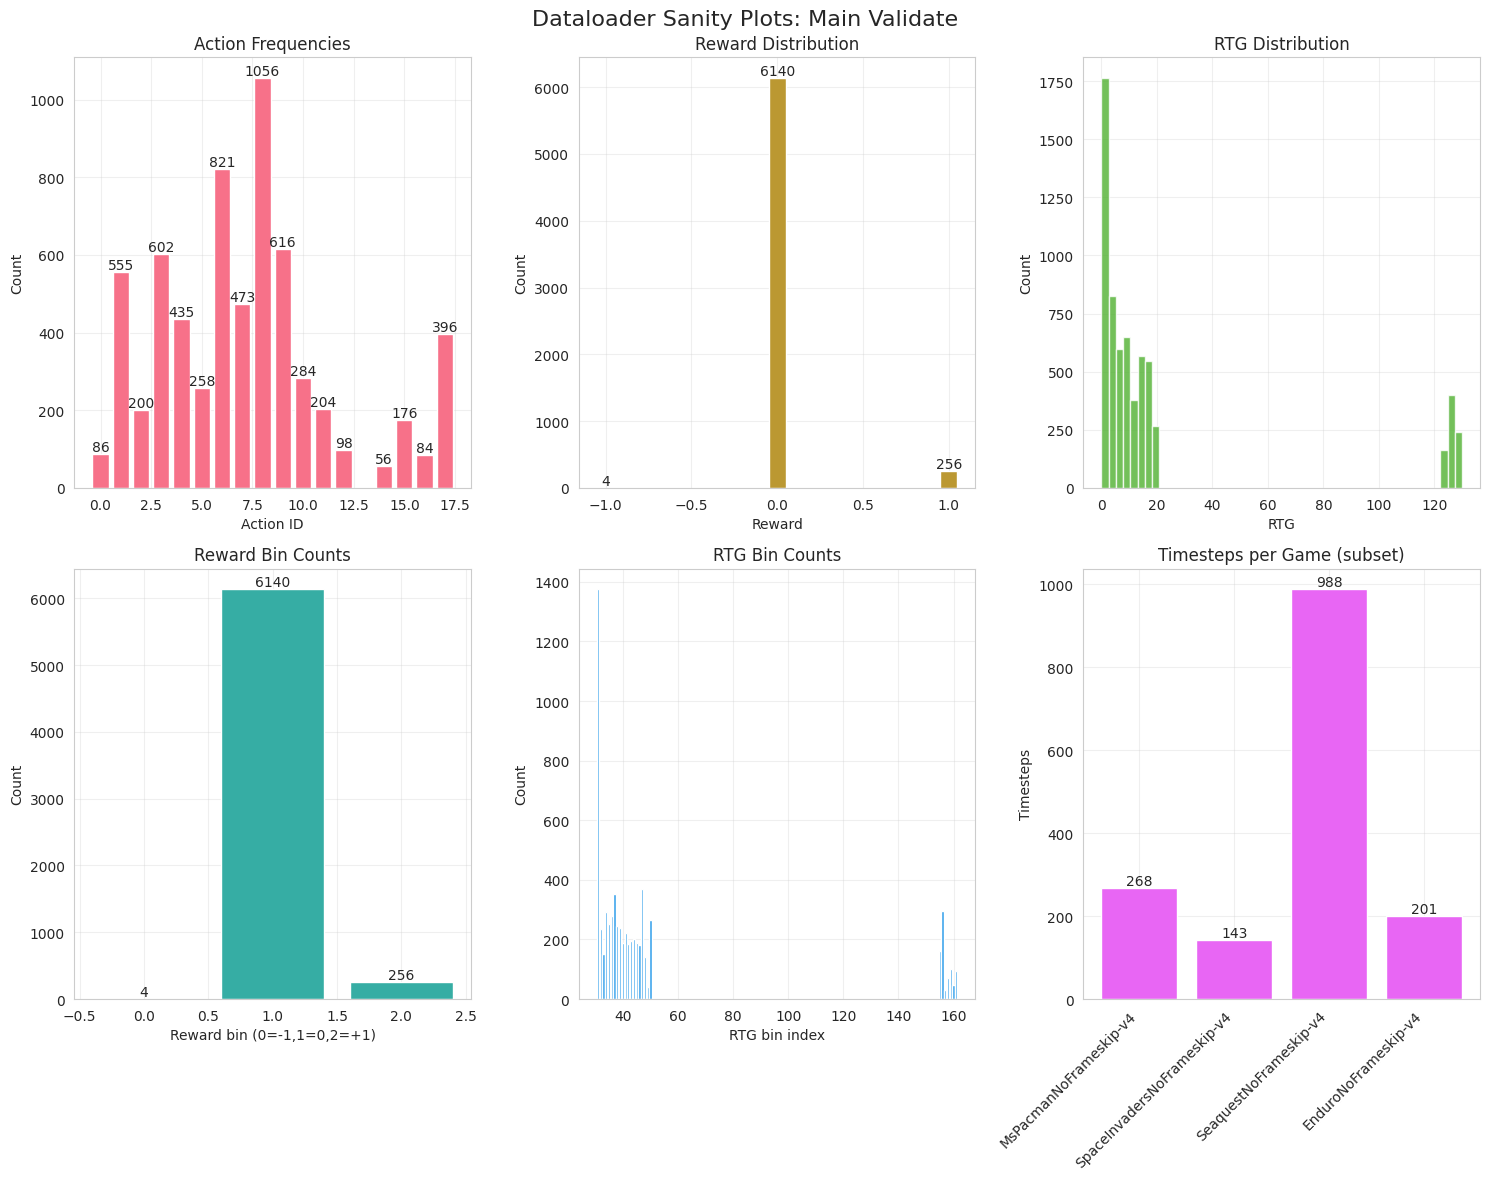

Dataloader size: 1151


In [10]:
from dataloader_stats import inspect_dataloader

_ = inspect_dataloader(main_bundle.train_loader, "Main Train", output_dir=OUTPUT_DIR)
_ = inspect_dataloader(main_bundle.val_loader, "Main Validate", output_dir=OUTPUT_DIR)

# Dataloader - Holdout Games

Saved plot to output/baseline/dataloader_holdout_train.png


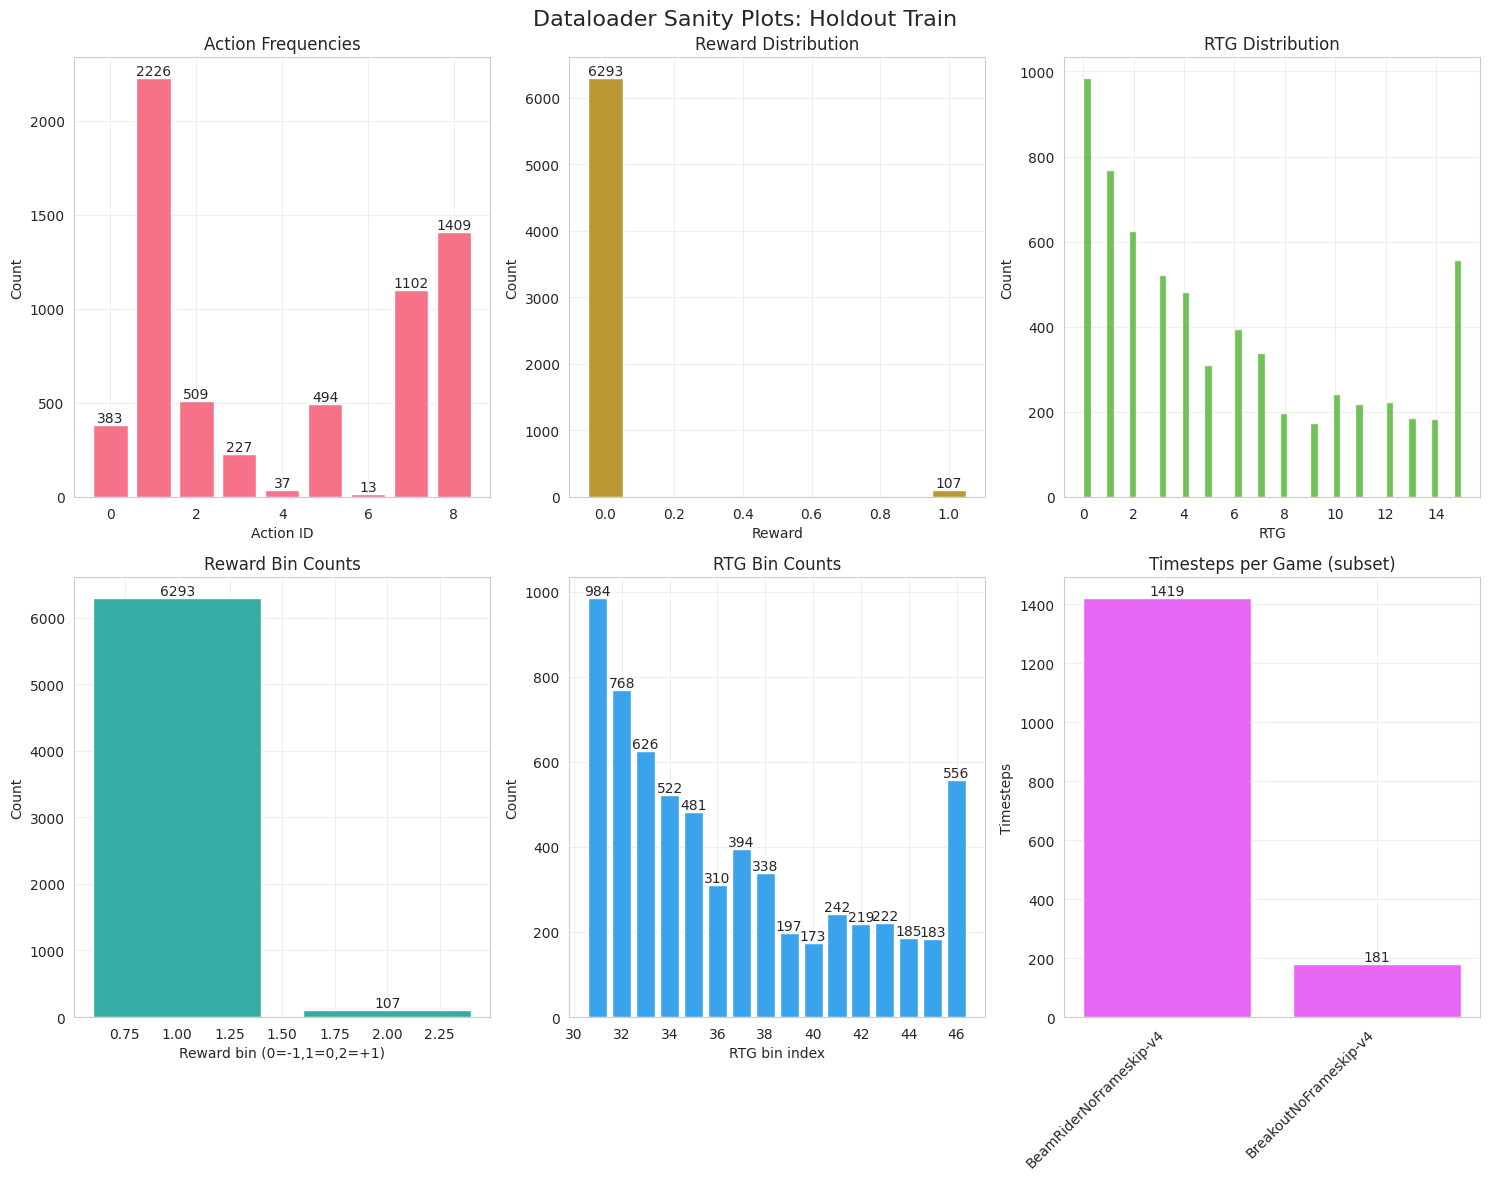

Dataloader size: 434
Saved plot to output/baseline/dataloader_holdout_validate.png


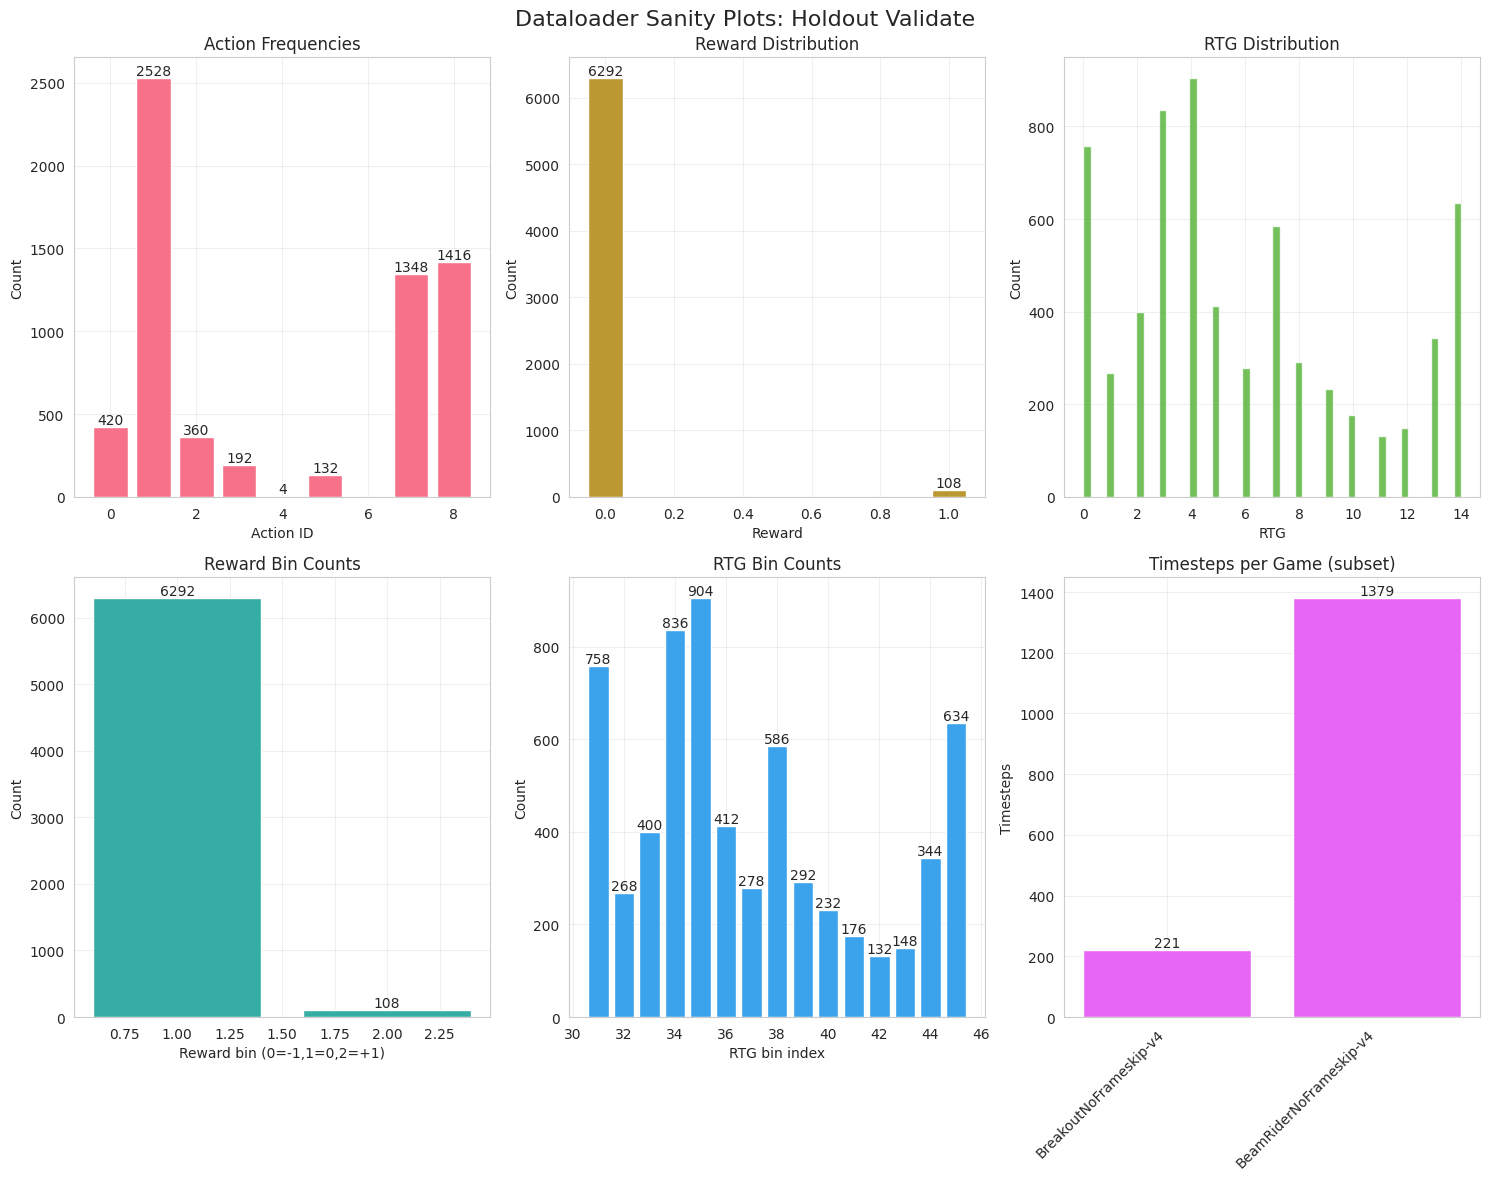

Dataloader size: 138


In [11]:
_ = inspect_dataloader(holdout_bundle.train_loader, "Holdout Train", output_dir=OUTPUT_DIR)
_ = inspect_dataloader(holdout_bundle.val_loader, "Holdout Validate", output_dir=OUTPUT_DIR)

# Train - Main Games

In [ ]:
from optuna_tuning import run_optuna


study = run_optuna(main_bundle.train_loader, main_bundle.val_loader, bins,
 lr_range = (1e-5, 1e-2),
  emb_size_choices = [64, 128, 256, 512],
                   n_layers_range = (2, 6),
                   n_heads_range=(1,4),
                   num_epochs_range=(1,2))
best_lr = study['learning_rate']
best_emb_size = study['embedding_size']
best_n_layers = study['num_layers']
best_n_heads = study['num_heads']
best_num_epochs = study['num_epochs']

[I 2025-12-09 04:54:38,726] A new study created in memory with name: no-name-a12c8d97-14de-4137-bdab-388174eb2638


Trial params: {'lr': 0.002226768831180977, 'emb_size': 128, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 4079/4079 [03:13<00:00, 21.03it/s]
[I 2025-12-09 05:02:25,731] Trial 0 finished with value: 0.3406560719013214 and parameters: {'lr': 0.002226768831180977, 'emb_size': 128, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 2}. Best is trial 0 with value: 0.3406560719013214.


Trial params: {'lr': 0.00011270129081078906, 'emb_size': 128, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 4079/4079 [03:15<00:00, 20.86it/s]
[I 2025-12-09 05:10:16,782] Trial 1 finished with value: 0.7840819358825684 and parameters: {'lr': 0.00011270129081078906, 'emb_size': 128, 'n_layers': 4, 'n_heads': 4, 'num_epochs': 2}. Best is trial 0 with value: 0.3406560719013214.
[I 2025-12-09 05:10:16,785] Trial 2 pruned. 


Trial params: {'lr': 0.0003741449617824379, 'emb_size': 64, 'n_layers': 2, 'n_heads': 3, 'num_epochs': 2}
Trial params: {'lr': 0.007433178424460421, 'emb_size': 128, 'n_layers': 5, 'n_heads': 4, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 4079/4079 [03:16<00:00, 20.74it/s]
[I 2025-12-09 05:14:13,762] Trial 3 finished with value: 1.1560755968093872 and parameters: {'lr': 0.007433178424460421, 'emb_size': 128, 'n_layers': 5, 'n_heads': 4, 'num_epochs': 1}. Best is trial 0 with value: 0.3406560719013214.


Trial params: {'lr': 1.3773999701051131e-05, 'emb_size': 64, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 4079/4079 [03:13<00:00, 21.06it/s]
[I 2025-12-09 05:22:01,723] Trial 4 finished with value: 3.1323132514953613 and parameters: {'lr': 1.3773999701051131e-05, 'emb_size': 64, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 2}. Best is trial 0 with value: 0.3406560719013214.
[I 2025-12-09 05:22:01,726] Trial 5 pruned. 


Trial params: {'lr': 0.0005959197181717317, 'emb_size': 64, 'n_layers': 4, 'n_heads': 3, 'num_epochs': 2}
Trial params: {'lr': 0.00048493324770872403, 'emb_size': 256, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 1}


Epoch 1/1: 100%|██████████| 4079/4079 [03:14<00:00, 20.99it/s]
[I 2025-12-09 05:25:55,804] Trial 6 finished with value: 0.7989607453346252 and parameters: {'lr': 0.00048493324770872403, 'emb_size': 256, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 1}. Best is trial 0 with value: 0.3406560719013214.
[I 2025-12-09 05:25:55,807] Trial 7 pruned. 


Trial params: {'lr': 0.00563170319611187, 'emb_size': 128, 'n_layers': 6, 'n_heads': 3, 'num_epochs': 1}
Trial params: {'lr': 0.0009677920332567837, 'emb_size': 256, 'n_layers': 2, 'n_heads': 4, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 4079/4079 [03:13<00:00, 21.08it/s]
[I 2025-12-09 05:33:43,327] Trial 8 finished with value: 0.41710004210472107 and parameters: {'lr': 0.0009677920332567837, 'emb_size': 256, 'n_layers': 2, 'n_heads': 4, 'num_epochs': 2}. Best is trial 0 with value: 0.3406560719013214.
[I 2025-12-09 05:33:43,330] Trial 9 pruned. 


Trial params: {'lr': 3.268720079314776e-05, 'emb_size': 128, 'n_layers': 3, 'n_heads': 3, 'num_epochs': 1}
Trial params: {'lr': 0.0021335325321830854, 'emb_size': 512, 'n_layers': 3, 'n_heads': 1, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 4079/4079 [03:20<00:00, 20.31it/s]
[I 2025-12-09 05:41:45,714] Trial 10 finished with value: 1.0077728033065796 and parameters: {'lr': 0.0021335325321830854, 'emb_size': 512, 'n_layers': 3, 'n_heads': 1, 'num_epochs': 2}. Best is trial 0 with value: 0.3406560719013214.


Trial params: {'lr': 0.0015711546447966952, 'emb_size': 256, 'n_layers': 3, 'n_heads': 1, 'num_epochs': 2}


Epoch 2/2: 100%|██████████| 4079/4079 [03:15<00:00, 20.84it/s]
[I 2025-12-09 05:49:36,832] Trial 11 finished with value: 0.7357215285301208 and parameters: {'lr': 0.0015711546447966952, 'emb_size': 256, 'n_layers': 3, 'n_heads': 1, 'num_epochs': 2}. Best is trial 0 with value: 0.3406560719013214.


Trial params: {'lr': 0.0013911111775011837, 'emb_size': 256, 'n_layers': 2, 'n_heads': 2, 'num_epochs': 2}


Epoch 2/2:  39%|███▉      | 1600/4079 [01:07<01:24, 29.18it/s]

In [ ]:
from mgdt_model_trainer import Encoder, train_mgdt

model, main_train_stats, main_val_stats = train_mgdt(
    bins=bins,
    dataloader_train=main_bundle.train_loader,
    dataloader_val=main_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=2,
    #lr=best_lr,
    #emb_size=best_emb_size,
    #n_layers=best_n_layers,
    #n_heads=best_n_heads
)

In [ ]:
from mgdt_model_stats import plot_losses
plot_losses(main_train_stats, main_val_stats, output_dir=OUTPUT_DIR, title_prefix="Main")

# Test Freeze

In [ ]:
from mgdt_model import Freezeable
model.freeze(components=[Freezeable.Transformer])

# Train - Holdout Games

In [ ]:
from mgdt_model_trainer import Encoder, train_mgdt

model, holdout_train_stats, holdout_val_stats = train_mgdt(
    model=model,
    bins=bins,
    dataloader_train=holdout_bundle.train_loader,
    dataloader_val=holdout_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=1,
)

In [ ]:
from mgdt_model_stats import plot_losses
plot_losses(holdout_train_stats, holdout_val_stats, output_dir=OUTPUT_DIR, title_prefix="Holdout")

# Comparison

In [ ]:
from mgdt_model_stats import plot_holdout_comparison

plot_holdout_comparison(main_train_stats, main_val_stats, holdout_train_stats, holdout_val_stats, output_dir=OUTPUT_DIR, title_prefix="Baseline")

# Model Info and Save

In [ ]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6:.0f}M")

In [ ]:
from utils import save_checkpoint

save_checkpoint(model, main_train_stats, main_val_stats, output_dir=OUTPUT_DIR)

In [ ]:
!zip -r output.zip output
from google.colab import files
files.download("output.zip")